### Cách đọc file thông thường và tf.data

#### ImageDataGenerator

In [1]:
%cd "/content/drive/MyDrive/grocery-images"

/content/drive/.shortcut-targets-by-id/1gVocdgOjp7dnVo8rM6lz1Io7VjaCD6nR/grocery-images


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from imutils import paths
from google.colab.patches import cv2_imshow
import tensorflow as tf 
import numpy as np
import pandas as pd
import os
import time

In [3]:
def benchmark(datasetGen, numSteps):
  start = time.time()
  
  for i in range(0, numSteps):
    images, labels = next(datasetGen)

  end = time.time()
  return end - start

In [4]:
cur_dir = os.getcwd()

In [5]:
numSteps = 1
BS = 64

In [6]:
imageGen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
dataGen = imageGen.flow_from_directory(
    cur_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=BS
)

Found 623 images belonging to 66 classes.


In [7]:
numSteps = 1
BS = 64

In [8]:
totalTime = benchmark(dataGen, numSteps)
print(f'ImageDataGenerator generates {BS * numSteps} images in {totalTime}')

ImageDataGenerator generates 64 images in 78.79027390480042


Dữ liệu chỉ 623 ảnh và batch size khá lớn nhưng phải tốn 18s để load dữ liệu một lần -> không hiệu quả

#### tf.data

In [9]:
imagePath = list(paths.list_images(cur_dir))
classNames = sorted(os.listdir(cur_dir))

In [10]:
i = tf.io.read_file(imagePath[0])
i = tf.image.decode_png(i, channels=3)

In [11]:
def load_images(imagePath, pretrained_net, required_size=(224, 224)):
  image = tf.io.read_file(imagePath) # đọc file
  image = tf.image.decode_png(image, channels=3) # chuyển về ảnh png
  image = tf.image.resize(image, required_size)  # kích thước đầu vào
  image = pretrained_net.preprocess_input(image) # tiền xử lí theo pretrained model

  label = tf.strings.split(imagePath, os.path.sep)[-2] # lấy tên nhãn
  oneHot = tf.cast(label == classNames, tf.int32) # thực hiện one-hot encoding
  return (image, oneHot)

In [12]:
def create_dataset(BS, pretrained_net):
  dataset = tf.data.Dataset.from_tensor_slices(imagePath)
  dataset = (dataset
            .shuffle(1024) # (1)
            .map(lambda x: load_images(x, pretrained_net), num_parallel_calls=AUTOTUNE) # (2)
            .cache() # (3)
            .repeat() # (4)
            .batch(BS) # (5)
            .prefetch(AUTOTUNE) # (6) 
            )
  return dataset

(1): khởi tạo một buffer có kích thước truyền vào, mỗi step lấy ra từ buffer số lượng dữ liệu tương ứng 1 batch size và lấy dữ liệu từ tập nguồn để làm đầy lại

(2): vì dữ liệu truyền vào là một danh sách các đường dẫn ảnh => hàm map ánh xạ từng phần tử và thực hiện phép biến đổi tương ứng

(3): caching để ghi nhớ lại dữ liệu đã sử dụng, tăng tốc độ tính toán

(4): Khi lấy hết dữ liệu từ tập nguồn thì cần làm đầy lại

(5): số lượng ảnh mỗi batch

(6): thực hiện song song việc chuẩn bị dữ liệu trước đó và tính toán dữ liệu hiện tại

In [13]:
dataset = create_dataset(BS, mobilenet_v2)
totalTime = benchmark(iter(dataset), numSteps)
print(f'tf.data API generates {BS * numSteps} in {totalTime}')

tf.data API generates 64 in 30.928186178207397


tf.data API nhanh hơn rất nhiều lần  ImageDataGenerator cho mỗi bước(dữ liệu trong 1 batch), con số này càng dao động đáng kể khi dữ liệu càng lớn

=> Sử dụng tf.data

In [14]:
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')

9412608/9406464 [==============================] - 0s 0us/step


thông thường batch size lớn sẽ lợi về thời gian tuy nhiên sẽ mất đi chút chính xác

dữ liệu tương đối ít nên sử dụng batch size nhỏ


In [15]:
BS = 16
epochs = 10
num_images = 623
steps_per_epoch = num_images // BS

In [16]:
dataset = create_dataset(BS, mobilenet_v2)

In [17]:
mobilenet.trainable = False

model = models.Sequential([
    mobilenet,
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(classNames.__len__(), activation='softmax')
]
)
model.compile(loss='categorical_crossentropy', metrics=['acc'])

In [18]:
history = model.fit(dataset, epochs=epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/10
38/38 [==============================] - 307s 7s/step - loss: 3.8656 - acc: 0.1053
Epoch 2/10
38/38 [==============================] - 6s 26ms/step - loss: 2.4563 - acc: 0.4539
Epoch 3/10
38/38 [==============================] - 1s 24ms/step - loss: 1.2834 - acc: 0.7237
Epoch 4/10
38/38 [==============================] - 1s 24ms/step - loss: 0.6833 - acc: 0.8684
Epoch 5/10
38/38 [==============================] - 1s 24ms/step - loss: 0.3733 - acc: 0.9375
Epoch 6/10
38/38 [==============================] - 1s 24ms/step - loss: 0.1994 - acc: 0.9688
Epoch 7/10
38/38 [==============================] - 1s 24ms/step - loss: 0.1028 - acc: 0.9868
Epoch 8/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0531 - acc: 0.9934
Epoch 9/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0388 - acc: 0.9951
Epoch 10/10
38/38 [==============================] - 1s 24ms/step - loss: 0.0103 - acc: 1.0000


In [19]:
model.save('mobilenet_v2.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


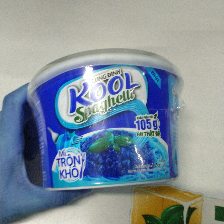

In [29]:
img_path = '/content/drive/MyDrive/grocery-images/MÌ LY TRỘN XỐT CÀ CHUA SPAGHETTI KOOL/IMG_20210602_220930.jpg'
img = tf.io.read_file(img_path)
img = tf.image.decode_png(img)
img = tf.image.resize(img, (224, 224))
cv2_imshow(img.numpy())

In [43]:
softmax_vector = model.predict(tf.expand_dims(img, axis=0))
max_val_idx = tf.argmax(softmax_vector, axis=1)[0]

In [45]:
classNames[max_val_idx]

'mì giấy (mì tôm)'

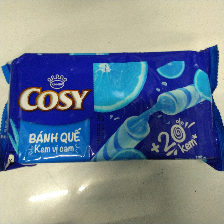

In [48]:
img_path = '/content/drive/MyDrive/grocery-images/bánh quế kem vị cam cosy/IMG_20210602_222053.jpg'
img = tf.io.read_file(img_path)
img = tf.image.decode_png(img)
img = tf.image.resize(img, (224, 224))
cv2_imshow(img.numpy())

In [50]:
softmax_vector = model.predict(tf.expand_dims(img, axis=0))
max_val_idx = tf.argmax(softmax_vector, axis=1)[0]
classNames[max_val_idx]

'mì giấy (mì tôm)'

In [53]:
max_val_idx

<tf.Tensor: shape=(), dtype=int64, numpy=36>